<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Generative-model-specifications" data-toc-modified-id="Generative-model-specifications-0"><span class="toc-item-num">0&nbsp;&nbsp;</span>Generative model specifications</a></span><ul class="toc-item"><li><span><a href="#Model-prior" data-toc-modified-id="Model-prior-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Model prior</a></span></li><li><span><a href="#Model-parameters-priors" data-toc-modified-id="Model-parameters-priors-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Model parameters priors</a></span></li><li><span><a href="#Generative-models" data-toc-modified-id="Generative-models-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Generative models</a></span></li><li><span><a href="#Data-generator" data-toc-modified-id="Data-generator-0.4"><span class="toc-item-num">0.4&nbsp;&nbsp;</span>Data generator</a></span></li></ul></li><li><span><a href="#Train-model-(KL,-no-smoothing)" data-toc-modified-id="Train-model-(KL,-no-smoothing)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Train model (KL, no smoothing)</a></span></li><li><span><a href="#Plot-accuracy-and-uncertainty-over-N" data-toc-modified-id="Plot-accuracy-and-uncertainty-over-N-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Plot accuracy and uncertainty over N</a></span><ul class="toc-item"><li><span><a href="#Plot-calibration" data-toc-modified-id="Plot-calibration-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Plot calibration</a></span></li></ul></li><li><span><a href="#OOD-Detection-(N=500)" data-toc-modified-id="OOD-Detection-(N=500)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>OOD Detection (N=500)</a></span></li><li><span><a href="#Train-model-(KL,-smoothing)" data-toc-modified-id="Train-model-(KL,-smoothing)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train model (KL, smoothing)</a></span></li><li><span><a href="#Figures-for-paper" data-toc-modified-id="Figures-for-paper-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Figures for paper</a></span><ul class="toc-item"><li><span><a href="#Plot-&quot;Dataset&quot;" data-toc-modified-id="Plot-&quot;Dataset&quot;-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Plot "Dataset"</a></span><ul class="toc-item"><li><span><a href="#Equally-probable" data-toc-modified-id="Equally-probable-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Equally probable</a></span></li><li><span><a href="#Equally-improbable" data-toc-modified-id="Equally-improbable-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>Equally improbable</a></span></li></ul></li><li><span><a href="#t-SNE" data-toc-modified-id="t-SNE-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>t-SNE</a></span></li></ul></li></ul></div>

In [13]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import tensorflow.contrib.eager as tfe
from functools import partial
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.tri as tri
from scipy import stats
from scipy.special import gamma as gamma_fun
import scipy.special as spec
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
np.set_printoptions(suppress=True)


from deep_bayes.models import DeepEvidentialModel
from deep_bayes.settings import EVIDENTIAL_DEFAULTS
from deep_bayes.training import train_online
from deep_bayes.losses import log_loss, cross_entropy
from deep_bayes.viz import plot_model_samples, plot_confusion_matrix
from deep_bayes.diagnostics import accuracy, expected_calibration_error

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
tf.enable_eager_execution()

In [16]:
%matplotlib inline

# Generative model specifications

## Model prior 
<p>Defines the prior probabilities over models $p(\boldsymbol{m})$.</p>

In [17]:
def model_prior(batch_size, n_models, p_vals=None):
    """
    Samples from the models' prior batch size times and converts to one-hot.
    Assumes equal model priors.
    ----------
    
    Arguments:
    batch_size : int  -- the number of samples to draw from the prior
    n_models   : int  -- the number of generative models in queston
    ----------
    
    Returns:
    m_true : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """
    
    # Equal priors, if nothign specified
    if p_vals is None:
        p_vals = [1/n_models] * n_models
    m_idx = np.random.choice(n_models, size=batch_size, p=p_vals).astype(np.int32)
    return m_idx

## Model parameters priors
<p>Defines how parameters are generated given a model $p(\boldsymbol{\theta}|\boldsymbol{m})$.</p>

In [18]:
def exponential_prior(**args):
    """
    Samples from the prior of the first model.
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
    """
    
    # Just as a toy example, sample from 2-D unit Gaussian
    theta = 1. / np.random.exponential(scale=1.)
    return theta


def lognormal_prior(**args):
    """
    Samples from the prior of the second model.
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
    """
    
    # Just as a toy example, sample from 2-D Gaussian with mean 1
    theta = np.random.normal(loc=0., scale=1.)
    return theta


def gamma_prior(**args):
    """
    Samples from the prior of the third model.
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
    """
    
    # Just as a toy example, sample from 2-D unit Gaussian with mean 2
    theta = np.random.exponential(scale=1.)
    return theta

## Generative models
<p>Defines how the data are generated, that is, $\boldsymbol{x}_{1:N} \sim p(\boldsymbol{x}|\boldsymbol{\theta},\boldsymbol{m}).$

In [19]:
def exponential_model(scale, n_obs, **args):
    """
    Runs the forward model once, i.e., generates a sample from p(x|theta, m).
    ----------
    
    Arguments:
    params : np.ndarray of shape (theta_dim, ) -- the data generating parameters
    n_obs  : int -- the numebr of observations to draw from p(x|theta)
    ----------
    
    Output:
    x      : np.ndarray of shape (n_obs, x_dim)
    """
    
    x = np.random.exponential(scale=scale, size=(n_obs, 1))
    return x


def lognormal_model(mean, n_obs, **args):
    """
    Runs the forward model once, i.e., generates a sample from p(x|theta, m).
    ----------
    
    Arguments:
    params : np.ndarray of shape (theta_dim, ) -- the data generating parameters
    n_obs  : int -- the numebr of observations to draw from p(x|theta)
    ----------
    
    Output:
    x      : np.ndarray of shape (n_obs, x_dim)
    """
    
    x = np.random.lognormal(mean=mean, sigma=1., size=(n_obs, 1))
    return x


def gamma_model(scale, n_obs, **args):
    """
    Runs the forward model once, i.e., generates a sample from p(x|theta, m).
    ----------
    
    Arguments:
    params : np.ndarray of shape (theta_dim, ) -- the data generating parameters
    n_obs  : int -- the numebr of observations to draw from p(x|theta)
    ----------
    
    Output:
    x      : np.ndarray of shape (n_obs, x_dim)
    """
    
    x = np.random.gamma(shape=2., scale=scale, size=(n_obs, 1))
    return x

In [20]:
from scipy.special import gamma

def marginal_lik_exponential(x):
    """
    Computes the log marginal likelihood of a batch of samples under an exponential model.
    ----------
    
    Arguments:
    x - a 3D np.ndarray of shape N_batch x  
    """
    
    
    n = x.shape[1]
    xx = np.log(gamma(n + 1)) - (n+1)*np.log(1 + np.sum(x, axis=(1, 2)))
    return xx


def marginal_lik_lognormal(x):
    """
    Computes the marginal likelihood of a batch of samples under a lognormal model.
    ----------
    
    Arguments:
    x - a 3D np.ndarray of shape N_batch x  
    """
    
    n = x.shape[1]
    xx = -((np.sum(np.log(x), axis=(1, 2)))**2) / (2*n*(n+1))
    xx -= (np.sum(np.log(x)**2, axis=(1, 2))**2) / 2
    xx += (np.sum(np.log(x), axis=(1, 2))**2) / (2*n)
    xx -= np.sum(np.log(x), axis=(1, 2))
    xx -= n * 0.5 * np.log(2*np.pi)
    xx -= 0.5 * np.log(n+1)
    return xx

def marginal_lik_gamma(x):
    """
    Computes the marginal likelihood of a batch of samples under a gamma model.
    ----------
    
    Arguments:
    x - a 3D np.ndarray of shape N_batch x  
    """
    
    n = x.shape[1]
    xx = np.sum(np.log(x), axis=(1, 2))
    xx += np.log(gamma(2*n + 1))
    xx -= n*np.log(gamma(2))
    xx -= (2*n+1) * np.log(1 + np.sum(x, axis=(1, 2)))
    return xx

## Data generator
<p>Define the algorithm:</p>
1. <strong>for</strong> $i = 1,...,B$<br>
2. &emsp;$\boldsymbol{m}^{(i)} \sim p(\boldsymbol{m})$<br>
3. &emsp;$\boldsymbol{\theta}^{(i)} \sim p(\boldsymbol{\theta}|\boldsymbol{m}^{(i)})$<br>
4. &emsp;$\boldsymbol{x}_{1:N}^{(i)} \sim p(\boldsymbol{x}|\boldsymbol{\theta}^{(i)},\boldsymbol{m}^{(i)})$

In [21]:
def data_generator(batch_size, model_prior, param_priors, forward_models, alpha_smooth=None,
                   n_obs=None, n_obs_min=100, n_obs_max=500, to_tensor=True, **args):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    ----------
    
    Arguments:
    batch_size     : int -- the number of samples to draw from the prior
    model_prior    : callable -- the prior which returns a sample of model indices
    param_priors   : list of callables -- a list with model prior samplers
    forward_models : list of generative models g(theta) -- a list of generatibve models
    alpha_smooth   : float or None -- the label smoothing hyperparameter
    n_obs          : int -- the numebr of observations to draw from p(x|theta)
    n_obs_min      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    n_obs_max      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    to_tensor      : boolean -- converts theta and x to tensors if True
    ----------
    
    Output:
    m     : tf.Tensor or np.ndarray of shape (batch_size, n_models) - the one-hot encoded version of the models
    theta : tf.Tensor or np.ndarray of shape (batch_size, theta_dim) - the data gen parameters 
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """
    
    # Sample from model prior
    # m_indices is an np.int32 array of model indices  
    n_models = len(forward_models)
    m_indices = model_prior(batch_size, n_models)
    
    # Sample N, if not specified
    if n_obs is None:
        n_obs = np.random.randint(low=n_obs_min, high=n_obs_max+1)
    
    # For each model index, sample from prior and run generative model.
    x = []
    theta = []
    for m_idx in m_indices:
        
        # Draw from model prior theta ~ p(theta|
        theta_m = param_priors[m_idx]()
        
        # Generate data from x = g_m(theta) <=> x ~ p(x|theta,m)
        x_m = forward_models[m_idx](theta_m, n_obs)
        
        # Store data and params
        x.append(x_m)
        theta.append(theta_m)
    
    # One-hot encode model indices
    m = to_categorical(m_indices, num_classes=n_models)
    
    # Apply label smoothing, if specified
    if alpha_smooth is not None:
        m = m * (1 - alpha_smooth) + alpha_smooth / n_models
    
    # Convert to tensor, if specified 
    if to_tensor:
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        m = tf.convert_to_tensor(m, dtype=tf.float32)
    return {'m': m, 'theta': theta, 'x': x}

# Train model (KL, no smoothing)

In [61]:
def train_models(lambdas, alpha_smooth=None, epochs=50, iterations_per_epoch=1000, batch_size=64):
    
    #--- Training hyperparameters ---#
    n_test = 500
    n_obs_min = 1
    n_obs_max = 500
    alpha_smooth = alpha_smooth

    #--- Optimizer hyperparameters ---#
    starter_learning_rate = 0.0005
    decay_steps = 1000
    decay_rate = .95
    
    #--- Data generation ---#
    param_priors = [exponential_prior, lognormal_prior, gamma_prior]
    forward_models = [exponential_model, lognormal_model, gamma_model]
    data_gen = partial(data_generator, 
                       model_prior=model_prior, 
                       param_priors=param_priors,
                       forward_models=forward_models,
                       n_obs_min=n_obs_min,
                       n_obs_max=n_obs_max,
                       alpha_smooth=alpha_smooth)
    
    # Loop for all lambdas
    for i, lambd in enumerate(lambdas):
        
        # Model 
        model = DeepEvidentialModel(EVIDENTIAL_DEFAULTS)
        
        # Optimizer
        global_step = tfe.Variable(0, dtype=tf.int32)
        learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                                   decay_steps, decay_rate, staircase=True)
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        
        # Checkpoint
        if alpha_smooth is None:
            ckpt_file = "toy_model_selection_evidential_kl_{}".format(lambd)
        else:
            ckpt_file = "toy_model_selection_evidential_kl_smooth_{}".format(lambd)
        checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
        manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=2)
        
        # Train current model
        for ep in range(1, epochs + 1):
            with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
                losses = train_online(model=model, 
                                      optimizer=optimizer, 
                                      data_gen=data_gen, 
                                      loss_fun=partial(log_loss, lambd=lambd), 
                                      iterations=iterations_per_epoch,
                                      batch_size=batch_size,
                                      p_bar=p_bar,
                                      global_step=global_step,
                                      method='evidence')
                manager.save()

In [23]:
lambdas = [0, 0.5, 1.0]
# train_models(lambdas)

In [24]:
#--- Data generation ---#
n_obs_min = 1
n_obs_max = 500
param_priors = [exponential_prior, lognormal_prior, gamma_prior]
forward_models = [exponential_model, lognormal_model, gamma_model]
data_gen = partial(data_generator, 
                   model_prior=model_prior, 
                   param_priors=param_priors,
                   forward_models=forward_models,
                   n_obs_min=n_obs_min,
                   n_obs_max=n_obs_max)

In [31]:
# Evaluate accuracy, uncertainty and calibration as a function of n
n_increment = 10
n_test = 5000
n_chunks = 10
models = {l: {'model': None, 'cal': [], 'u': [], 'acc': []} for l in lambdas}
for lambd in lambdas:
    
    model = DeepEvidentialModel(EVIDENTIAL_DEFAULTS)
    ckpt_file = "toy_model_selection_evidential_kl_{}".format(lambd)
    checkpoint = tf.train.Checkpoint(net=model)
    manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=2)
    checkpoint.restore(manager.latest_checkpoint)
    models[lambd]['model'] = model

In [32]:
# Compute accuracy, uncertainty and calibration error as a function of N
for n in range(n_obs_min, n_obs_max+2, n_increment):
    
    # Create test data
    test_data_c = data_gen(n_test, n_obs=n)
    
    for model in models.values():

        # Predict without blowing off GPU memory
        preds = [model['model'].predict(x, to_numpy=True) 
                 for x in tf.split(test_data_c['x'], n_chunks, axis=0)]

        # Extract probs and uncertainties
        m_p = np.concatenate([p['m_probs'] for p in preds])
        u_p = np.concatenate([p['uncertainty'] for p in preds])

        # Compute calibration errors
        cal_errs, cal_probs = expected_calibration_error(test_data_c['m'], m_p)

        # Compute accuracy
        acc = accuracy(test_data_c['m'], m_p)

        # Store
        model['cal'].append(np.mean(cal_errs))
        model['acc'].append(acc)
        model['u'].append(np.mean(u_p))

# Plot accuracy and uncertainty over N

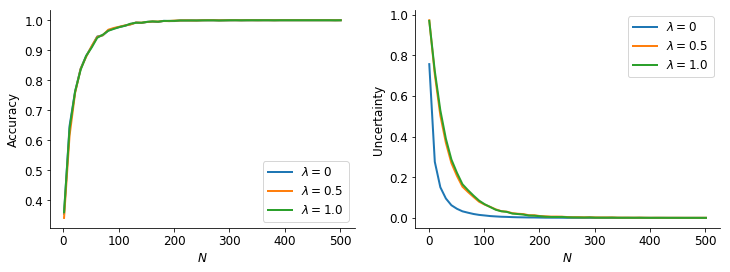

In [47]:
plt.rcParams['font.size'] = 12

# Plot stuff
f, axarr = plt.subplots(1, 2, figsize=(12, 4))
for l, model in models.items():
    
    axarr[0].plot(range(n_obs_min, 
                        n_obs_max+2, n_increment), 
                  model['acc'], label=r'$\lambda={}$'.format(l), lw=2)
    
    axarr[1].plot(range(n_obs_min, 
                        n_obs_max+2, 
                        n_increment), 
                  model['u'], label=r'$\lambda={}$'.format(l), lw=2)
    
axarr[0].spines['right'].set_visible(False)
axarr[0].spines['top'].set_visible(False)
axarr[0].set_xlabel(r'$N$')
axarr[0].set_ylabel(r'Accuracy')
axarr[0].legend()

axarr[1].spines['right'].set_visible(False)
axarr[1].spines['top'].set_visible(False)
axarr[1].set_xlabel(r'$N$')
axarr[1].set_ylabel(r'Uncertainty')
axarr[1].legend()
f.tight_layout()
f.savefig('figures/Acc_KL.png', dpi=300)

## Plot calibration

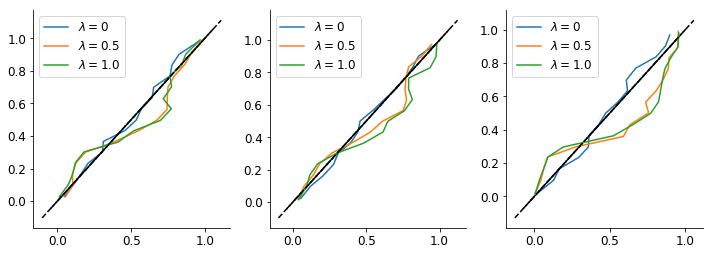

In [49]:
test_data_cal = data_gen(5000, n_obs=20)
n_chunks = 10

f, axarr = plt.subplots(1, 3, figsize=(12, 4))

for l, model in models.items():
    
    # Compute calibrations
    m_p = np.concatenate([model['model'].predict(x, to_numpy=True)['m_probs'] 
                          for x in tf.split(test_data_cal['x'], n_chunks, axis=0)])
    cal_errs, cal_probs = expected_calibration_error(test_data_cal['m'], m_p)
    
    for i, ax in enumerate(axarr):
        ax.plot(cal_probs[i][0], cal_probs[i][1], label=r'$\lambda={}$'.format(l))
        ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.legend()
f.savefig('figures/Cal_KL.png', dpi=300)

# OOD Detection (N=500)

In [73]:
test_data_ood = data_gen(500, n_obs=50)

uncertainties = {l: [] for l in lambdas}

# Loop through models
for l, model in models.items():
    # Loop through shifts
    for k in np.linspace(0, 20, 10):
        # Compute uncertainty on shifted data
        u = model['model'].predict(test_data_ood['x'] + k, to_numpy=True)['uncertainty'].mean()
        uncertainties[l].append(u)

In [74]:
uncertainties

{0: [0.055699494,
  0.22906306,
  0.3827765,
  0.53416425,
  0.594791,
  0.59624195,
  0.5777723,
  0.5484849,
  0.48940253,
  0.4147196],
 0.5: [0.23161146,
  0.51670533,
  0.658573,
  0.7588027,
  0.8159415,
  0.8472804,
  0.8549701,
  0.8420716,
  0.81701326,
  0.78641504],
 1.0: [0.26102448,
  0.44532934,
  0.66367936,
  0.810147,
  0.8933463,
  0.92357177,
  0.92046815,
  0.9080188,
  0.8856205,
  0.85492176]}

ValueError: x and y must have same first dimension, but have shapes (100,) and (10,)

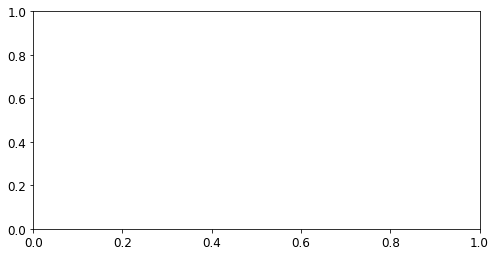

In [67]:
f, ax = plt.subplots(1, 1, figsize=(8, 4))
for l, u in uncertainties.items():
    ax.plot(np.linspace(0, 50, 100), u, label=r'$\lambda={}$'.format(l))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend()

# Train model (KL, smoothing)

In [51]:
lambdas = [0, 0.5, 1.0]
train_models(lambdas, alpha_smooth=0.1)

array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
        0.50505051,  0.60606061,  0.70707071,  0.80808081,  0.90909091,
        1.01010101,  1.11111111,  1.21212121,  1.31313131,  1.41414141,
        1.51515152,  1.61616162,  1.71717172,  1.81818182,  1.91919192,
        2.02020202,  2.12121212,  2.22222222,  2.32323232,  2.42424242,
        2.52525253,  2.62626263,  2.72727273,  2.82828283,  2.92929293,
        3.03030303,  3.13131313,  3.23232323,  3.33333333,  3.43434343,
        3.53535354,  3.63636364,  3.73737374,  3.83838384,  3.93939394,
        4.04040404,  4.14141414,  4.24242424,  4.34343434,  4.44444444,
        4.54545455,  4.64646465,  4.74747475,  4.84848485,  4.94949495,
        5.05050505,  5.15151515,  5.25252525,  5.35353535,  5.45454545,
        5.55555556,  5.65656566,  5.75757576,  5.85858586,  5.95959596,
        6.06060606,  6.16161616,  6.26262626,  6.36363636,  6.46464646,
        6.56565657,  6.66666667,  6.76767677,  6.86868687,  6.96

# Figures for paper

In [270]:
from functools import reduce
import math

def xy2bc(xy, corners, midpoints, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / reduce(mul, [gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * reduce(mul, [xx ** (aa - 1)
                                         for (xx, aa)in zip(x, self._alpha)])
    
def draw_pdf_contours(dist, nlevels=200, subdiv=8, **kwargs):
    
    
    
    f, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
    midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
             for i in range(3)]
    triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy, corners, midpoints)) for xy in zip(trimesh.x, trimesh.y)]

    ax.tricontourf(trimesh, pvals, nlevels, **kwargs)
    ax.axis('equal')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 0.75**0.5])
    ax.axis('off')
    return f

## Plot "Dataset"

In [257]:
data_1 = np.random.multivariate_normal(mean=[1, 1], cov=np.eye(2) / 2, size=1000)
data_2 = np.random.multivariate_normal(mean=[3, 4], cov=np.eye(2) / 2, size=1000)
data_3 = np.random.multivariate_normal(mean=[4, 1], cov=np.eye(2) / 2, size=1000)

### Equally probable

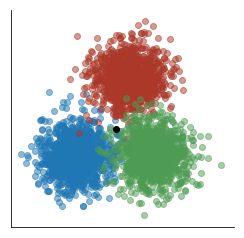

In [305]:
f, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(data_1[:, 0], data_1[:, 1], alpha=0.5, color='#1f77b4')
ax.scatter(data_2[:, 0], data_2[:, 1], alpha=0.5, color='#ab3829')
ax.scatter(data_3[:, 0], data_3[:, 1], alpha=0.5, color='#4e9c53')
ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# Plot point at an equal distance to clouds
ax.scatter(2.5, 2, color='black')
f.savefig("figures/clouds1.png", dpi=600, bbox_inches='tight')

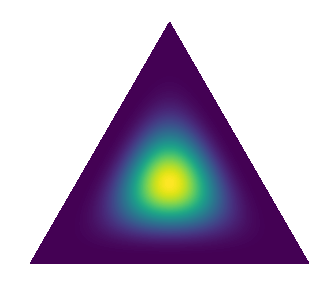

In [316]:
alphas = np.array([5, 5, 5])
probs = alphas / alphas.sum()
var = (probs * (1 - probs)) / (alphas.sum() + 1) 
f = draw_pdf_contours(Dirichlet(alphas), n_levels=100, subdiv=8, cmap='viridis')
f.savefig("figures/dirichlet1.png", dpi=600, bbox_inches='tight')

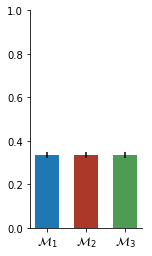

In [317]:
f, ax = plt.subplots(1, 1, figsize=(2, 4))
ax.bar([0, 1, 2], probs, width=0.6, align='center', color=('#1f77b4', '#ab3829', '#4e9c53'), yerr=var)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels([r'$\mathcal{M}_1$', r'$\mathcal{M}_2$', r'$\mathcal{M}_3$'], fontsize=12)
ax.set_ylim([0, 1.0])
f.savefig("figures/probs1.png", dpi=600, bbox_inches='tight')

### Equally improbable

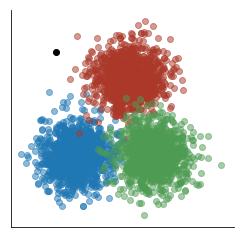

In [308]:
f, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(data_1[:, 0], data_1[:, 1], alpha=0.5, color='#1f77b4')
ax.scatter(data_2[:, 0], data_2[:, 1], alpha=0.5, color='#ab3829')
ax.scatter(data_3[:, 0], data_3[:, 1], alpha=0.5, color='#4e9c53')
ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# Plot point at an equal distance to clouds
ax.scatter(0.2, 5, color='black')
f.savefig("figures/clouds2.png", dpi=600, bbox_inches='tight')

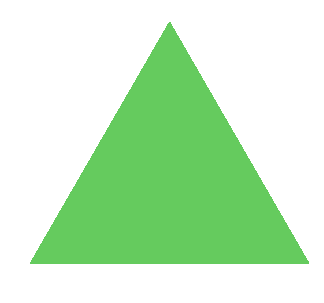

In [318]:
alphas = np.array([1, 1, 1])
probs = alphas / alphas.sum()
var = (probs * (1 - probs)) / (alphas.sum() + 1) 
f = draw_pdf_contours(Dirichlet(alphas), n_levels=100, subdiv=8, cmap='viridis')
f.savefig("figures/dirichlet2.png", dpi=600, bbox_inches='tight')

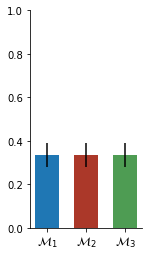

In [320]:
f, ax = plt.subplots(1, 1, figsize=(2, 4))
ax.bar([0, 1, 2], probs, width=0.6, align='center', color=('#1f77b4', '#ab3829', '#4e9c53'), yerr=var)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels([r'$\mathcal{M}_1$', r'$\mathcal{M}_2$', r'$\mathcal{M}_3$'], fontsize=12)
ax.set_ylim([0, 1.0])
f.savefig("figures/probs2.png", dpi=600, bbox_inches='tight')

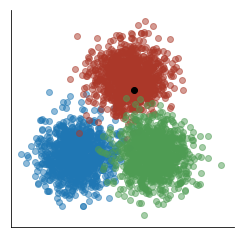

In [311]:
f, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(data_1[:, 0], data_1[:, 1], alpha=0.5, color='#1f77b4')
ax.scatter(data_2[:, 0], data_2[:, 1], alpha=0.5, color='#ab3829')
ax.scatter(data_3[:, 0], data_3[:, 1], alpha=0.5, color='#4e9c53')
ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# Plot point at an equal distance to clouds
ax.scatter(3.2, 3.5, color='black')
f.savefig("figures/clouds3.png", dpi=600, bbox_inches='tight')

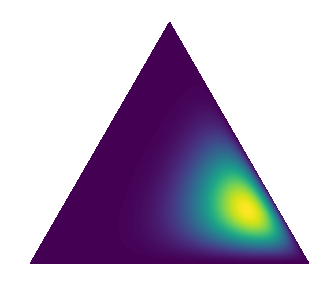

In [321]:
alphas = np.array([2, 7, 3])
probs = alphas / alphas.sum()
var = (probs * (1 - probs)) / (alphas.sum() + 1) 
f = draw_pdf_contours(Dirichlet(alphas), n_levels=100, subdiv=8, cmap='viridis')
f.savefig("figures/dirichlet3.png", dpi=600, bbox_inches='tight')

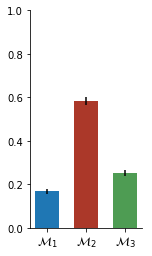

In [322]:
f, ax = plt.subplots(1, 1, figsize=(2, 4))
ax.bar([0, 1, 2], probs, width=0.6, align='center', color=('#1f77b4', '#ab3829', '#4e9c53'), yerr=var)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels([r'$\mathcal{M}_1$', r'$\mathcal{M}_2$', r'$\mathcal{M}_3$'], fontsize=12)
ax.set_ylim([0, 1.0])
f.savefig("figures/probs3.png", dpi=600, bbox_inches='tight')

## t-SNE

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.010s...
[t-SNE] Computed neighbors for 500 samples in 0.047s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 1.848185
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.847454
[t-SNE] KL divergence after 1000 iterations: 0.101740


Text(0.5, 1.0, 'Latent space projection predicted')

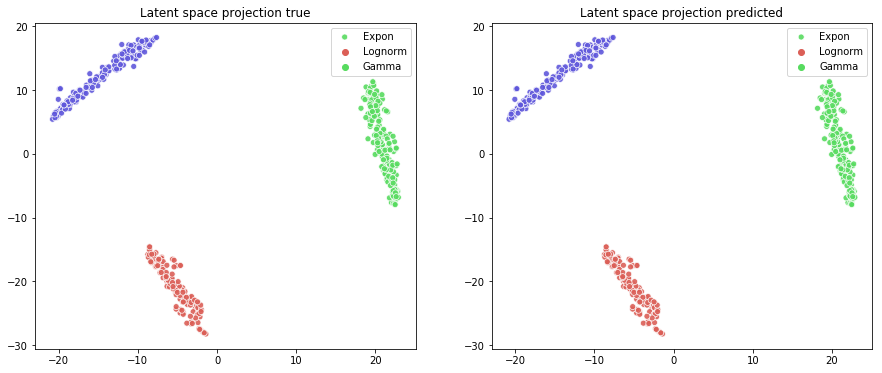

In [326]:
test_data_min = data_gen(n_test, n_obs=20)
test_data_max = data_gen(n_test, n_obs=n_obs_max)


summary = model.compute_summary(test_data['x']).numpy()
m_pred = model(test_data['x'])['m_probs'].numpy().argmax(axis=1)

tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(summary)


f, ax = plt.subplots(1, 2, figsize=(15, 6))

g = sns.scatterplot(
    x=tsne_results[:, 0], 
    y=tsne_results[:, 1],
    hue=test_data['m'].numpy().argmax(axis=1),
    palette=sns.color_palette("hls", 3),
    legend="full",
    alpha=0.9,
    ax=ax[0]
)

g = sns.scatterplot(
    x=tsne_results[:, 0], 
    y=tsne_results[:, 1],
    hue=m_pred,
    palette=sns.color_palette("hls", 3),
    legend="full",
    alpha=0.9,
    ax=ax[1]
)

ax[0].legend(model_names)
ax[1].legend(model_names)

ax[0].set_title('Latent space projection true')
ax[1].set_title('Latent space projection predicted')